# bonus 2b

In [117]:
import cv2
import numpy as np

def calculate_nucleus_cytoplasm_ratio(image_path):
    img = cv2.imread(image_path)
    height, width, _ = img.shape

    mask = img[:, width // 2:]  # get the right half


    nucleus_mask = np.all(mask == [255,0,0], axis=-1)  #  boolean mask for nucleus
    cytoplasm_mask = np.all(mask == [0,255,0], axis=-1)  # boolean mask for cytoplasm

    # count pixels
    nucleus_pixels = np.count_nonzero(nucleus_mask)
    cytoplasm_pixels = np.count_nonzero(cytoplasm_mask)

    # compute the ratio
    ratio = nucleus_pixels / (nucleus_pixels + cytoplasm_pixels )

    return nucleus_pixels, cytoplasm_pixels, ratio

image_path = "./cyto2label_public/train/100.png"  
nucleus, cytoplasm, ratio = calculate_nucleus_cytoplasm_ratio(image_path)
print(f"Nucleus Pixels: {nucleus}, Cytoplasm Pixels: {cytoplasm}, Ratio: {ratio:.2f}")

Nucleus Pixels: 3541, Cytoplasm Pixels: 31395, Ratio: 0.10


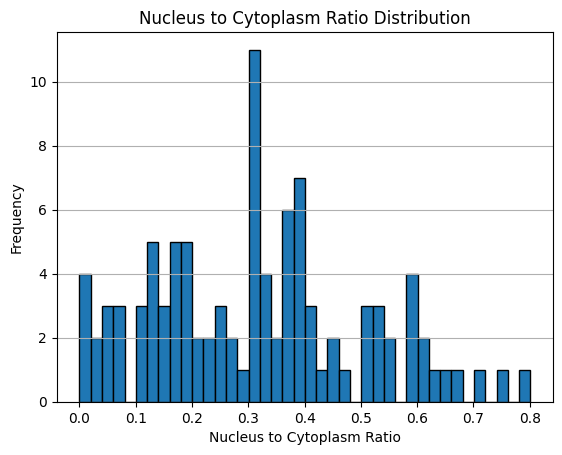

 mean: 0.316042591619443, median: 0.31078486976933806


In [3]:

import os
import glob
image_dir = "./cyto2label_public/train/"
image_paths = glob.glob(os.path.join(image_dir, "*.png"))
ratios = []
for image_path in image_paths:
    nucleus, cytoplasm, ratio = calculate_nucleus_cytoplasm_ratio(image_path)
    ratios.append(ratio)

# plot the ratios as a distribution
import matplotlib.pyplot as plt
plt.hist(ratios, bins=40, edgecolor='black')
plt.title('Nucleus to Cytoplasm Ratio Distribution')
plt.xlabel('Nucleus to Cytoplasm Ratio')
plt.ylabel('Frequency')
plt.grid(axis='y', )
plt.show()

# compute mean and median of ratios
import numpy as np
mean_ratio = np.mean(ratios)
median_ratio = np.median(ratios)
print(f" mean: {mean_ratio}, median: {median_ratio}") # the distrubution is likely normal


### Hypothesis:
- H0: If the average NC ratio is significantly above the threshold then the population is likely to be cancerous 
- Ha: There is no significant relationship between an average NC ratio above the threshold and the likelihood of the population being cancerous.

In [4]:
from scipy import stats
import math
def z_test(expression_values, threshold=4):
    n = len(expression_values)
    sample_mean = expression_values.mean()
    standard_error = expression_values.std(ddof=0) / math.sqrt(n)
    z_score = (sample_mean - threshold) / standard_error
    p_value = 1 - stats.norm.cdf(z_score)  

    malignant = sample_mean > threshold
    
    return p_value, malignant  

# try on testing data
image_dir = "./cyto2label_public/test/"
image_paths = glob.glob(os.path.join(image_dir, "*.png"))
ratios = []
for image_path in image_paths:
    nucleus, cytoplasm, ratio = calculate_nucleus_cytoplasm_ratio(image_path)
    ratios.append(ratio)

ratios = np.array(ratios)

ratios.mean(), z_test(ratios, threshold=mean_ratio)

(0.25055868874386594, (0.9991207486196894, False))

Conclusion: The testing data is likely not malignant

## bonus

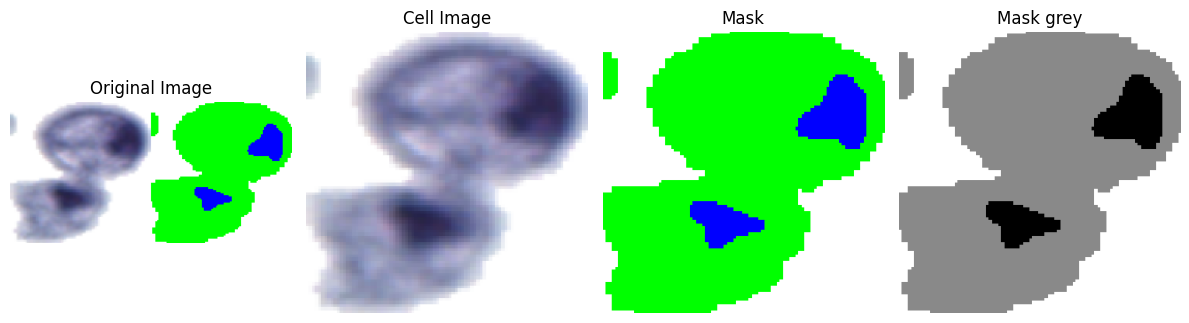

In [7]:

img = cv2.imread("./cyto2label_public/train/100.png")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape
cell_image = img_rgb[:, :w//2, :]
mask = img_rgb[:, w//2:, :]

mask_grey = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(12, 8))

# og image
plt.subplot(1, 4, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')

# cell image
plt.subplot(1, 4, 2)
plt.imshow(cell_image)
plt.title("Cell Image")
plt.axis('off')

# mask
plt.subplot(1, 4, 3)
plt.imshow(mask)
plt.title("Mask")
plt.axis('off')


# mask
plt.subplot(1, 4, 4)
plt.imshow(mask_grey, cmap='gray')
plt.title("Mask grey")
plt.axis('off')


plt.tight_layout()
plt.show()


In [5]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import numpy as np
import torch
from PIL import Image

class CellSegmentationDataset(Dataset):
    def __init__(self, image_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        
        # loan image  in bgr format
        img = cv2.imread(img_path)
        
        h, w, _ = img.shape
        cell_image = img[:, :w//2, :]  # left half = image
        mask = img[:, w//2:, :]        # right half = mask
        
        # convert mask to grayscale
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        # create the 3 classes
        output = np.zeros_like(mask, dtype=np.uint8)  # class 0
        output[(mask > 85) & (mask < 170)] = 1  # class 1
        output[mask >= 170] = 2  # class 2
      
        cell_image = self.transform(Image.fromarray(cell_image))
        
       
        mask_pil = Image.fromarray(output)
        mask_pil = self.mask_transform(mask_pil)  
        
       # change to long tensor for cross entropy loss
        mask_tensor = torch.tensor(np.array(mask_pil), dtype=torch.long)
        
        return cell_image, mask_tensor

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((128, 128), interpolation=Image.NEAREST),
])

# Create datasets
train_dataset = CellSegmentationDataset("./cyto2label_public/train/", transform=transform, mask_transform=mask_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = CellSegmentationDataset("./cyto2label_public/test/", transform=transform, mask_transform=mask_transform)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [1]:
import segmentation_models_pytorch as smp
# pretrained unett model
model = smp.Unet(encoder_name="resnet34",   # resnet18 for good speed and accuracy
                 encoder_weights="imagenet",  # using pretrained weights improved accuracy
                 in_channels=3,  # input = 3 channel bgr images 
                 classes=3, # output = 0 for nucleus, 2 for cytoplasm, 3 for background
                ) 

/Users/advaithmalka/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
# Training Loop
from torch import optim
from torch import nn
import torch
from tqdm import tqdm

num_epochs = 10
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


model = model.to(device)
loss_fn = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    
    for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Move data to device
        images = images.to(device)  # Already float32 from transforms
        masks = masks.to(device)    # Already long from dataset
    
        # Forward pass
        outputs = model(images)  # Shape: [batch, 2, H, W]
        
        loss = loss_fn(outputs, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_dataloader)
    
    # Validation
    val_loss = 0.0
    val_iou = 0.0
    model.eval()
    with torch.no_grad():
        for images, masks in test_dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Loss
            val_loss += loss_fn(outputs, masks).item()
            
           
    avg_val_loss = val_loss / len(test_dataloader)

    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | ")


Using device: mps


Epoch 1/10: 100%|██████████| 25/25 [00:04<00:00,  6.05it/s]


Epoch 1/10 | Train Loss: 0.4592 | Val Loss: 0.3821 | 


Epoch 2/10: 100%|██████████| 25/25 [00:02<00:00, 10.34it/s]


Epoch 2/10 | Train Loss: 0.3500 | Val Loss: 0.3317 | 


Epoch 3/10: 100%|██████████| 25/25 [00:02<00:00, 10.43it/s]


Epoch 3/10 | Train Loss: 0.3121 | Val Loss: 0.3051 | 


Epoch 4/10: 100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Epoch 4/10 | Train Loss: 0.2853 | Val Loss: 0.2916 | 


Epoch 5/10: 100%|██████████| 25/25 [00:02<00:00, 10.50it/s]


Epoch 5/10 | Train Loss: 0.2758 | Val Loss: 0.2955 | 


Epoch 6/10: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Epoch 6/10 | Train Loss: 0.2536 | Val Loss: 0.2750 | 


Epoch 7/10: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Epoch 7/10 | Train Loss: 0.2370 | Val Loss: 0.2692 | 


Epoch 8/10: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Epoch 8/10 | Train Loss: 0.2435 | Val Loss: 0.2567 | 


Epoch 9/10: 100%|██████████| 25/25 [00:02<00:00, 10.69it/s]


Epoch 9/10 | Train Loss: 0.2282 | Val Loss: 0.2724 | 


Epoch 10/10: 100%|██████████| 25/25 [00:02<00:00, 10.91it/s]


Epoch 10/10 | Train Loss: 0.2110 | Val Loss: 0.2797 | 


In [7]:
# save model
torch.save(model.state_dict(), "./models/unett_cyto2label.pt")

In [8]:
import torch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.load_state_dict(torch.load("./models/unett_cyto2label.pt", map_location=device))
model.eval() 

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

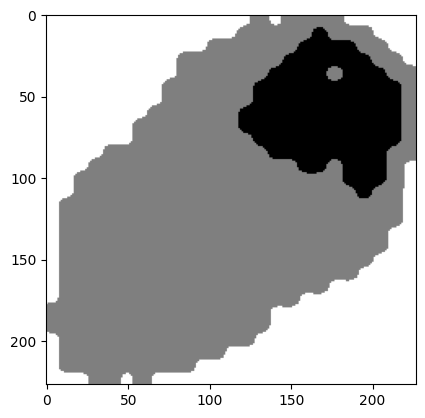

In [ ]:
img = cv2.imread("./cyto2label_public/test/0.png")
h, w, _ = img.shape
cell_image = img[:, :w//2, :]
ground_truth_mask = img[:, w//2:, :]
ground_truth_mask = cv2.cvtColor(ground_truth_mask, cv2.COLOR_BGR2GRAY)
output = np.zeros_like(ground_truth_mask)  
output[(ground_truth_mask > 85) & (ground_truth_mask < 170)] = 127  
output[ground_truth_mask >= 170] = 255 
np.unique(output)

plt.imshow(output, cmap='gray')

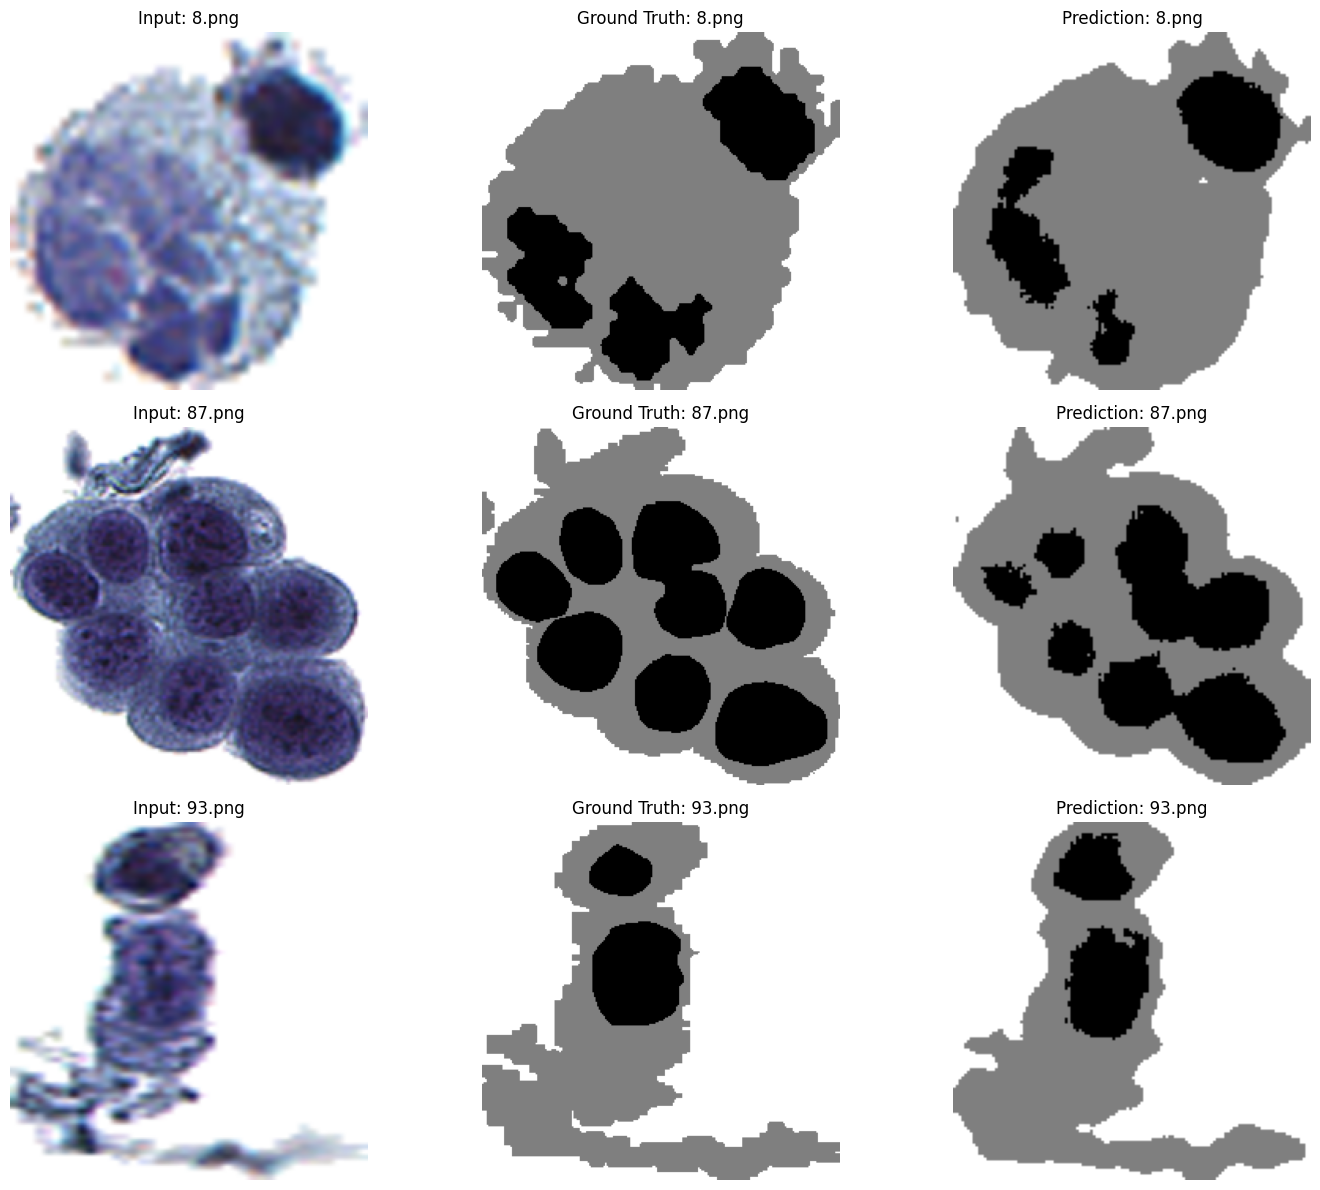

In [ ]:
from matplotlib import pyplot as plt
import torch
import torchvision.transforms as transforms
import cv2
import numpy as np
import os

def predict(image_path, model, device):
    # load and split image left and right
    img = cv2.imread(image_path)
    h, w, _ = img.shape
    cell_image = img[:, :w//2, :]
    ground_truth_mask = img[:, w//2:, :]

    # convert cell to rgb
    cell_image_rgb = cv2.cvtColor(cell_image, cv2.COLOR_BGR2RGB)
    cell_image_resized = cv2.resize(cell_image_rgb, (128, 128))

    # conver to greyscale
    ground_truth_mask_gray = cv2.cvtColor(ground_truth_mask, cv2.COLOR_BGR2GRAY)

    # format mask for display
    gt_display = np.zeros_like(ground_truth_mask_gray, dtype=np.uint8)
    gt_display[(ground_truth_mask_gray > 85) & (ground_truth_mask_gray < 170)] = 127  # Gray
    gt_display[ground_truth_mask_gray >= 170] = 255  # White

    # scale and normalize to 0-1
    cell_image_tensor = transforms.ToTensor()(cell_image_resized).unsqueeze(0).to(device)

    with torch.inference_mode():
        output = model(cell_image_tensor)
        
        predicted_mask = torch.argmax(output, dim=1).cpu().numpy()[0]
        
       
        pred_display = np.zeros_like(predicted_mask, dtype=np.uint8) # set everything to 0
        pred_display[predicted_mask == 1] = 127  # class 1 = grey
        pred_display[predicted_mask == 2] = 255  # class 2 = white 
    
    return cell_image_rgb, gt_display, pred_display

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


model = model.to(device)
model.eval()  

image_paths = [
    "./cyto2label_public/test/8.png",
    "./cyto2label_public/test/87.png",
    "./cyto2label_public/test/93.png"
]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, image_path in enumerate(image_paths):
    filename = os.path.basename(image_path)
    
    # Get predictions
    cell_image, gt_mask, pred_mask = predict(image_path, model, device)
    
    # plot input image
    axes[i, 0].imshow(cell_image)
    axes[i, 0].set_title(f"Input: {filename}")
    axes[i, 0].axis("off")
    
    # plot ground truth 
    axes[i, 1].imshow(gt_mask, cmap='gray')
    axes[i, 1].set_title(f"Ground Truth: {filename}")
    axes[i, 1].axis("off")
    
    # plot predicted mask
    axes[i, 2].imshow(pred_mask, cmap='gray')
    axes[i, 2].set_title(f"Prediction: {filename}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

In [121]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import os
from sklearn.metrics import mean_squared_error

def get_nc_ratio(mask, is_gt=True):
    if is_gt:
        # convert to grayscale 
       
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
        # define pixel classes
        nucleus_mask = mask <= 85  # White pixels (nucleus)
        cytoplasm_mask = (mask > 85) & (mask < 170)  # Gray pixels (cytoplasm)
    
    else:
        nucleus_mask = mask == 0
        cytoplasm_mask = mask == 1

    nucleus_pixels = np.count_nonzero(nucleus_mask)
    cytoplasm_pixels = np.count_nonzero(cytoplasm_mask)

    # compute ratio
    if cytoplasm_pixels == 0:
        return float('inf') if nucleus_pixels > 0 else 0
    return nucleus_pixels / cytoplasm_pixels

def process_images(folder, model, device):
    files = [f for f in os.listdir(folder) if f.endswith('.png')] # get all files in folder
    
    gt_ratios, pred_ratios = [], []

    for file in files:
        img = cv2.imread(os.path.join(folder, file))
        h, w, _ = img.shape

        # split ground truth and cell image
        cell_img = img[:, :w//2, :]
        gt_mask = img[:, w//2:, :]

        # get ground truth NC ratio
        gt_ratios.append(get_nc_ratio(gt_mask, is_gt=True))

        # process image for model
        img_rgb = cv2.cvtColor(cell_img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (128, 128))
        img_tensor = transforms.ToTensor()(img_resized).unsqueeze(0).to(device)

        # get predicted segmentation
        model.eval()
        with torch.no_grad():
            pred_mask = torch.argmax(model(img_tensor), dim=1).cpu().numpy()[0]

        # get NC ratio
        pred_ratios.append(get_nc_ratio(pred_mask, is_gt=False))

    # compute MSE
    mse = mean_squared_error(gt_ratios, pred_ratios)
    return mse

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

folder_path = "./cyto2label_public/test"
mse = process_images(folder_path, model, device)

print(f"MSE between Ground Truth and Predicted NC Ratios: {mse:.4f}")

MSE between Ground Truth and Predicted NC Ratios: 0.2013
